In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision
from GenerativeAdversarialNetwork import GenerativeAdversarialNetwork
import torch
import wandb
import os
from Util import *


In [2]:
# N.B. don't apply one-hot encoding on labels - we don't need them (unsupervised learning)
# Applying ToTensor() transform to change type(data) to torch.Tensor
my_transform_1 = torchvision.transforms.ToTensor()
my_transforms = torchvision.transforms.Compose([my_transform_1])

# Set download=True first time to acquire dataset
_MNIST_DATASET = torchvision.datasets.MNIST(root="data/",
                                            download=False,
                                            train=True,
                                            transform=my_transforms)


In [3]:
# Picking out numbers from dataset
numbers = [9]
_MNIST_DATASET.data = _MNIST_DATASET.data[keep_numbers(numbers,_MNIST_DATASET)]
_MNIST_DATASET.targets = _MNIST_DATASET.targets[keep_numbers(numbers,_MNIST_DATASET)]


In [4]:
# Configuration
_USE_WANDB = False
_DEVICE    = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#_DEVICE = torch.device("cpu")



epochs      = 25
batch_size  = 128
sample_size = 10    # Number of random values to sample

g_lr        = 0.00001  # Generator's learning rate
d_lr        = 0.00001  # Discriminator's learning rate
lrs = (d_lr,g_lr)

g_betas     = (0.5, 0.9) # 0.9 , 0.999 are adam standard
d_betas     = (0.5, 0.9) # 0.9 , 0.999 are adam standard
betas       = (d_betas,g_betas)

g_wd        = 0.0 # Generator's weight decay
d_wd        = 0.0 # Discriminator's weight decay
wds = (d_wd,g_wd)

label_smooth = 0.15 # real_label=1 --> 1*(1-label_smooth), fake_label=0 --> 0+label_smooth

In [5]:
# Setting up dataloader
_MNIST_DATALOADER = DataLoader(_MNIST_DATASET,
                               batch_size=batch_size,
                               drop_last=True)
my_net = GenerativeAdversarialNetwork(latent_size=sample_size)

Using device:  cuda:0


In [6]:
config_dict = \
    {
    "Loss function": "Binary Cross Entropy",
    "Optimizer": "Adam",
    "Learning_rates (D, G)": lrs,
    "Epochs": epochs,
    "Batch_size": _MNIST_DATALOADER.batch_size,
    "Weight_decays (D, G)": wds,
    "D Betas": betas[0],
    "G Betas": betas[1],
    "One sided label smoothing": "1->1*(1-"+str(label_smooth)+")"+"and 0->0.0+"+str(label_smooth),
    "Nr. train data points": _MNIST_DATASET.__len__(),
    "Note": "'Mode collapse' fixed w. normalization in seems to keep happening."
    }

if _USE_WANDB:
    run = wandb.init(project="semi-working DCGAN for MNIST",
               config=config_dict,
               save_code=False,
               notes="Problems w. mode collapse",
               mode="online")

    wandb.watch(my_net)

Initial map: 


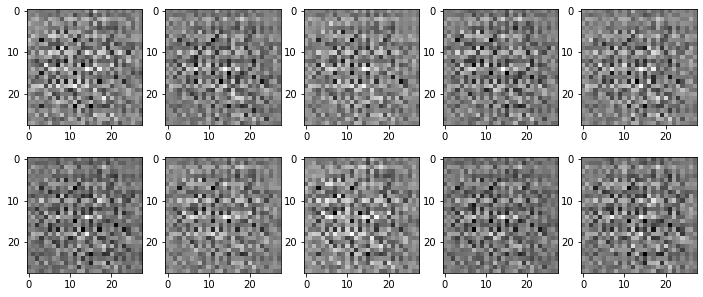

In [7]:
# Display random datapoint
print("Initial map: ")
rows = 2
cols = 5
my_net.eval()
fig, ax = plt.subplots(rows,cols, figsize= (12,5))
for row in range(rows):
    for col in range(cols):
        Z = torch.rand(size=(1,sample_size),device=_DEVICE)
        X_hat = my_net.generator.forward(Z).reshape((28, 28)).cpu().detach().numpy()
        ax[row][col].imshow(X_hat, cmap="gray")
plt.show()

In [8]:
my_net.train()
d_loss, g_loss = my_net.train_network(dataloader =_MNIST_DATALOADER, lrs = lrs, wds = wds,
                                      epochs = epochs, label_smooth = label_smooth, betas=betas,
                                      save_images=False, use_wandb=_USE_WANDB)

100%|██████████| 25/25 [05:47<00:00, 13.89s/it]


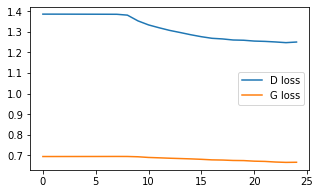

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
epocs = [i for i in range(len(d_loss))]
ax.plot(epocs,d_loss,label="D loss")
ax.plot(epocs,g_loss,label="G loss")
ax.legend()
plt.show()

final map: 


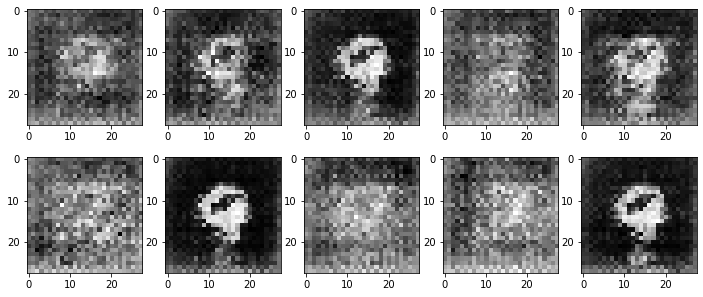

In [10]:
# Display random datapoint
print("final map: ")
rows = 2
cols = 5
my_net.eval()
fig, ax = plt.subplots(rows,cols, figsize= (12,5))
for row in range(rows):
    for col in range(cols):
        Z = torch.rand(size=(1,sample_size),device=_DEVICE)
        X_hat = my_net.generator.forward(Z).reshape((28, 28)).cpu().detach().numpy()
        ax[row][col].imshow(X_hat, cmap="gray")
plt.show()

In [11]:
# Deleting all photos
import os
delete_photos = False
if delete_photos:
    os.system("cd progress_pics && rm *.jpg")

In [12]:
# Save config settings used in run
if _USE_WANDB:
    save_config_dict(config_dict)
    run.save(os.getcwd()+"wandb/latest-run/files/my_config.txt")
    run.save(os.getcwd()+"wandb/latest-run/files/requirements.txt")